# Cluster synchrony demo

This notebook shows how to build and train a KuraNet instance for learning couplings which promote cluster synchrony in the Kuramoto model. We will consider an equilibrium Kuramoto model of the form $$\dot{\theta_i} = \sum_j K_{ij}\sin(\theta_j(t) - \theta_i(t))$$
where $(K)_{ij} \in \mathcal{K}$ is an $n \times n$ coupling matrix. Each oscillator, $i$, is associated to an i.i.d. random feature $x_i\in \mathbb{R}^2 \subset \mathcal{X}$ which has a label $y_i = y(x_i) \in {1, \ldots, k}$. Absuing terminology, we consider these random features to be the "quenched disorder" of KuraNet since they affect the long-term learning dynamics, even if they don't influence the short-term evolution. 

We will use a deep neural network to approximate the function $\mathcal{X}^n \times \mathcal{X}^n \to \mathcal{K}$ that makes the oscillators synchronize into clusters respecting the labels, $y_i$. This deep neural network is trained to produe couplings which minimize the circular variance within each group and a potential measuring desynchrony between all groups. If target cluster $l$, has mean phase $\langle \theta \rangle_l(t)$, the desynchrony potential is $$S= \lim_{t\to \infty} \sum_g^k \frac{1}{2g^2k}\left| \sum_l^k e^{ig\langle \theta \rangle_l(t)}\right|^2.$$

First, we load some modules and set the CUDA device. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from models import KuraNet_xy
from train import optimize_connectivity_net
from data import make_data, make_all_data
from utils import circular_variance, circular_moments, cohn_loss, make_masks
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

## Make data and set parameters

Next we generate and save the Gaussian mixture features. You can run can also rewrite this code to learn cluster synchrony for the other simple mixsture distributions discussed in the companion manuscript. 

This is an equilibrium model and there is no external drive besides the random initialization to break the symmetry. Depending on your settings, you may see that the model converges to a bad local minimum (though the settings here should avoid that). Try a new random seed if that's the case. 

In [22]:
from os.path import expanduser
home = expanduser("~")
data_base_dir = os.path.join(home,'cluster_synchrony1')
if not os.path.exists(data_base_dir): os.makedirs(data_base_dir)

num_samples=10000
data_names=['GMM_5'] # For other experiments, change to e.g. ['Moons']
dist_names = ['GMM'] # For other experiments, change to e.g. ['Moons']
num_classes=5 # Make sure to set the correct number of classes for your data! E.g 'Moons' has 2. 

make_data(data_names[0], dist_names[0], data_base_dir=data_base_dir, num_samples=num_samples,num_classes=num_classes)


In [4]:
seed=0
num_classes=5
model_type='xy'
num_samples=10000
num_epochs=3
num_units=100
batch_size=100
feature_dim=2
avg_deg=1.0
num_hid_units=100
symmetric=True
normalize='graph'
device='cuda'
adjoint=True
initial_phase='normal'
solver_method='euler'
optimizer='Adam'
max_grad_norm=10.0
lr=5e-5
momentum=0.0
loss_type='circular_moments'
alpha=15
gd_steps=100
burn_in_steps=0
set_gain=True
gain=.5
measure_cx=False
rand_inds=False

num_batches = int(num_samples/num_units)

 # Set loss function
if loss_type == 'circular_variance':
    loss_func = circular_variance
elif loss_type == 'circular_moments':
    loss_func = circular_moments
elif loss_type == 'cohn_loss':
    loss_func = cohn_loss # This is an alterntive loss due to Cohn who used it for discussing Thomson's problem.
else:
    raise Exception('Loss type not recognized.')


# Load training and testing data.
train_dls  = {}
test_dls   = {}

for dl, regime in zip([train_dls, test_dls], ['train', 'test']):
    for dist_name, data_name in zip(dist_names, data_names):
        if dist_name != 'degenerate':
            dt = np.load(os.path.join(data_base_dir, data_name, dist_name, regime, 'features.npz'))
            ds = TensorDataset(torch.FloatTensor(dt['x']), torch.LongTensor(dt['y'].astype(np.int32)))
        else:
            ds = TensorDataset(torch.zeros(num_samples).float(), torch.zeros(num_samples).long())
        dl[data_name] = DataLoader(ds, batch_size=num_units, shuffle=True, drop_last=True)
data_keys = [key for key in train_dls.keys()]

## Training KuraNet

This cell trains the model on the selected experiment over `num_epochs` passes over the whole node feature data set. On each iteration, a sample of node features is drawn and then passed through the neural network that produces couplings. These couplings then participate in a Kuramoto dynamics whose final steps are evaluated by the specified loss function. 

In [5]:
np.random.seed(seed)
torch.manual_seed(seed)

loss_train, loss_test, kn, cx = optimize_connectivity_net(num_units, feature_dim, train_dls, test_dls, model_type=model_type,
                                                          num_classes=num_classes, avg_deg=avg_deg,
                                                          normalize=normalize, symmetric=symmetric,pretrained=False,
                                                          num_epochs=num_epochs,  batch_size=num_units, 
                                                          burn_in_steps=burn_in_steps, gd_steps=gd_steps,
                                                          alpha=alpha, initial_phase=initial_phase,
                                                          solver_method=solver_method, adjoint=adjoint,
                                                          loss_type=loss_type, optimizer=optimizer,
                                                          lr=lr, momentum=momentum, max_grad_norm=max_grad_norm,
                                                          set_gain=set_gain, gain=gain,
                                                          num_hid_units=num_hid_units, verbose=1, show_every=10,
                                                          num_eval_batches=10, rand_inds=rand_inds, device=device)

Training. Epoch 0.
Training batch: 0. Time/Batch: 1.0505. Loss: 0.39681562781333923. Gradient norm: 1.9420571854052437.
Training batch: 10. Time/Batch: 1.0018. Loss: 0.4007236659526825. Gradient norm: 0.8539122503998547.
Training batch: 20. Time/Batch: 1.0403. Loss: 0.38029032945632935. Gradient norm: 0.04002667430991185.
Training batch: 30. Time/Batch: 0.995. Loss: 0.37671583890914917. Gradient norm: 0.10866135720992723.
Training batch: 40. Time/Batch: 1.0389. Loss: 0.37754637002944946. Gradient norm: 0.07326072599355843.
Training batch: 50. Time/Batch: 1.0815. Loss: 0.37531036138534546. Gradient norm: 0.07246256706798586.
Training batch: 60. Time/Batch: 1.0142. Loss: 0.3573399782180786. Gradient norm: 10.0.
Training batch: 70. Time/Batch: 0.9901. Loss: 0.25232893228530884. Gradient norm: 9.862510633389643.
Training batch: 80. Time/Batch: 0.9926. Loss: 0.16579300165176392. Gradient norm: 9.43632910190325.
Training batch: 90. Time/Batch: 1.0153. Loss: 0.14479154348373413. Gradient norm

## Visualization

Now, let's view the training loss curve and a sample test dynamics. Uncomment the grid setting function to change the dynamic step size. This can sometimes make animations look more exciting. 

Optimized loss: 0.0851
Control loss: 0.2427


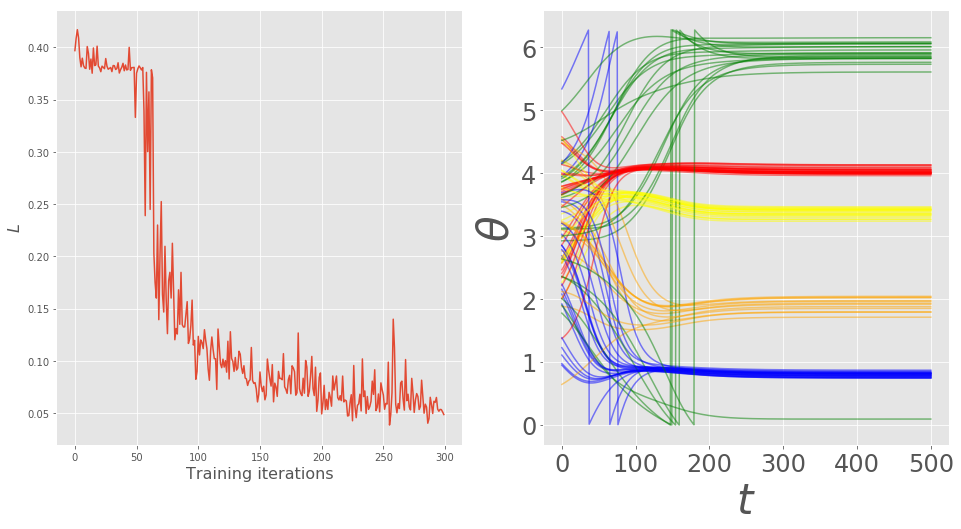

In [23]:
visualization_time=500

kn_control = KuraNet_xy(feature_dim, avg_deg=avg_deg,
             num_hid_units=num_hid_units, initial_phase=initial_phase,
             rand_inds=rand_inds,normalize=normalize,
             adjoint=adjoint, solver_method=solver_method,set_gain=False, gain=1.0,
             alpha=alpha, gd_steps=1,
             burn_in_steps=visualization_time).to(device)

kn_control.set_batch_size(batch_size)

# Sometimes the animations look better if you use a smaller step size. 
# kn.set_grids(1.0, visualization_time, 1)
# kn_control.set_grids(1.0, visualization_time, 1)

# Load one testing batch
for j, batch in enumerate(zip(*[test_dls[key] for key in data_keys])):
    X = {key : x.float().to(device) for (key, (x,_)) in zip(data_keys, batch)}
    Y = {key : y for (key, (_,y)) in zip(data_keys, batch)}
    # This is only used for cluster synchrony experiments
    if num_classes > 0:
        masks = make_masks(Y,num_classes,device)
    else:
        masks = None
    target = batch[0][1].numpy()
    break
# Sometimes animations look better if you increase the step size above that used during learning. 
flow = kn.run(X, full_trajectory=True)
flow_control = kn_control.run(X, full_trajectory=True)
print('Optimized loss: %.04f' % loss_func(flow[burn_in_steps:], masks=masks))
print('Control loss: %.04f' % circular_variance(flow_control[burn_in_steps:]))

flow = flow.data.cpu().numpy() 
flow_control=flow_control.data.cpu().numpy()

fig, axes = plt.subplots(1,2,figsize=(16,8))
all_colors = ['red', 'green', 'blue', 'orange', 'yellow', 'purple', 'pink', 'gray', 'black', 'magenta']

axes[0].plot(loss_train)
axes[0].set_xlabel('Training iterations', fontsize=16)
axes[0].set_ylabel(r'$L$', fontsize=16)

flow_colors = [all_colors[tg] for tg in target]

# flow = (flow % ((2 * np.pi) + 2 * np.pi)) % 2 * np.pi
flow %= 2*np.pi
# dflow = np.abs(np.concatenate((np.zeros((1,flow.shape[-1])), np.diff(flow,axis=0)), axis=0))
# flow = np.where(dflow > np.pi, np.nan, flow)
axes[1].set_prop_cycle('color', flow_colors)
axes[1].plot(flow, alpha=.5)
axes[1].set_xlabel(r'$t$',fontsize=42)
axes[1].set_ylabel(r'$\theta$',fontsize=42)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# axes[1].set_ylim([0,2*np.pi])
# fig.tight_layout(pad=6)

plt.show()
plt.close()

The loss should flatten out by the end of 300 iterations. On the right, you should see `num_classes` tight clusters of phases that should synchronize pretty quickly. The color of each trajectory corresponds to the groundtruth class of that oscillator

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
rc('animation', html='html5')

fig, axes = plt.subplots(1,2,figsize=(8,4))
flow_x         = np.cos(flow)
flow_x_control = np.cos(flow_control)
flow_y         = np.sin(flow)
flow_y_control = np.sin(flow_control)

frames = flow.shape[0]

def update(i):
    for ax, sc, fl, fl_cmp in zip(axes, [scatter0,scatter1], [flow, flow_control], [[flow_x, flow_y], [flow_x_control, flow_y_control]]):
#         angle = fl[i,...].mean()
        state = np.concatenate((fl_cmp[0][i,...].reshape(-1,1), fl_cmp[1][i,...].reshape(-1,1)),axis=-1)
#         cv = circular_variance(torch.tensor(fl[i,...])).numpy()
        sc.set_offsets(state)
#         ln.set_data([0, (1-cv)*np.cos(angle)],[0, (1-cv)*np.sin(angle)])
    return scatter0,scatter1

scatters = []
for ax, fl, fl_cmp in zip(axes,[flow, flow_control], [[flow_x, flow_y], [flow_x_control, flow_y_control]]):
    ax.set_xlim(( -1.25, 1.25))
    ax.set_ylim((-1.25, 1.25))
    ax.add_patch(plt.Circle((0, 0), 1.0, color='gray', fill=False))
    scatter = ax.scatter(fl_cmp[0][0,...], fl_cmp[1][0,...], color=flow_colors)
#     angle = fl[0,...].mean()
    state = np.concatenate((fl_cmp[0][0,...].reshape(-1,1), fl_cmp[1][0,...].reshape(-1,1)),axis=-1)
#     cv = circular_variance(torch.tensor(fl[0,...])).numpy()
#     line, = ax.plot([0, (1-cv)*np.cos(angle)],[0, (1-cv)*np.sin(angle)], color = cl, linewidth = 1)
#     lines.append(line)
    scatters.append(scatter)

scatter0 = scatters[0]
scatter1 = scatters[1]

anim = FuncAnimation(fig, update, frames=frames, blit=True, interval=20)
html = HTML(anim.to_html5_video())
display(html)
plt.close() # update
# Save
# anim.save(os.path.join(home, 'kuramoto.mp4'), writer='ffmpeg', fps=45)


More likely than not, the control model (right) will converge into antipodal clusters, which often happens with mixed positive/negative couplings. The trained model, on the other hand, should begin to equidistribute the unit circle. The quality of this equidistribution will depend on the random initialization and how many epochs you used during training, the latter generally improving the regularity of the arrangement. 